In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
from regimeaware.routines import cfg
from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW
from itertools import permutations
import seaborn as sns

NUM_STATES = 3
NUM_STOCKS = 1000
SIM_PERIODS = 600
MIN_OBS = 300
FCTRS = ["mktrf", "smb", "hml", "rmw", "cma", "umd"]
AS_OF_DT = datetime(2024, 12, 31)

In [2]:
fctr_rt = pd.read_pickle(f"{cfg.fldr}/data/ff.pkl").loc[:AS_OF_DT, FCTRS]
crsp = pd.read_pickle(f"{cfg.fldr}/data/crsp.pkl")
sec_rt = crsp["excess_ret"]
mcap = crsp["mktcap"].xs(AS_OF_DT)

# Sample selection
obs_count = sec_rt.loc[:, pd.IndexSlice[mcap.index]].groupby("permno").count()
sample_ids = obs_count[obs_count >= MIN_OBS].index

In [3]:
# Train HMM based on real data
mdl_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type=cfg.hm_cov,
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)

mdl_hmm.fit(fctr_rt)
smoothed_prob = pd.DataFrame(mdl_hmm.predict_proba(fctr_rt), index=fctr_rt.index, columns=range(NUM_STATES))
hmm_startprob = mdl_hmm.startprob_
hmm_transmat = mdl_hmm.transmat_
hmm_means = mdl_hmm.means_
hmm_covars = mdl_hmm.covars_

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [4]:
# Collect regime-weighted parameters of our sample stocks
collect_params = {}
collect_scale = {}
for sec_id in sample_ids:
    y = sec_rt.xs(sec_id, level="permno").dropna()
    
    state_params = []
    for s in range(NUM_STATES):
        w = smoothed_prob.loc[y.index, s]
        mdl = sm.WLS(y, sm.add_constant(fctr_rt.loc[y.index, FCTRS]), weights=w).fit(disp=0)
        b = mdl.params.copy()
        b.index = pd.MultiIndex.from_product([b.index, [s]], names=["factor", "state"])
        state_params += [b]
        collect_scale[(sec_id, s)] = mdl.scale

    collect_params[sec_id] = pd.concat(state_params)

_midx = pd.MultiIndex.from_product([FCTRS, range(NUM_STATES)], names=["state", "factor"])
sample_params = pd.DataFrame.from_dict(collect_params, orient="index").loc[sample_ids, _midx]
scale_by_regime = pd.Series(collect_scale).groupby(level=1).mean()

In [5]:
pd.Series(collect_scale)

10026  0    0.004173
       1    0.001524
       2    0.001150
10028  0    0.023364
       1    0.009449
              ...   
92655  1    0.001588
       2    0.001226
92807  0    0.003375
       1    0.001405
       2    0.000825
Length: 3657, dtype: float64

In [6]:
# Loadings join-distribution (market-cap weighted)
wstats = DescrStatsW(sample_params, weights=mcap.reindex(sample_ids))

loadings_means = pd.Series(wstats.mean, index=_midx)

_temp_cov = pd.DataFrame(wstats.cov, index=_midx, columns=_midx)
loadings_cov = pd.DataFrame(0, index=_midx, columns=_midx)
for f in FCTRS:
    loadings_cov.loc[f, f] = _temp_cov.loc[f, f].values

In [7]:
# Generate synthetic stock returns
gen_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type=cfg.hm_cov,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)

# Seeds
gen_hmm.random_state = cfg.hm_rs
np.random.seed(cfg.hm_rs)

gen_hmm.startprob_ = hmm_startprob
gen_hmm.transmat_ = hmm_transmat
gen_hmm.means_ = hmm_means
gen_hmm.covars_ = np.array([np.diag(x) for x in hmm_covars])

X, Z = gen_hmm.sample(SIM_PERIODS)
G = gen_hmm.predict_proba(X)

# True factor loadings
_vals = np.random.multivariate_normal(mean=loadings_means, cov=loadings_cov, size=NUM_STOCKS)
B = pd.DataFrame(_vals, columns=loadings_means.index).T
B.columns.name = "stock"
B.index.names = ["factor", "state"]
B = B.stack()

# Stock returns
R = np.zeros((SIM_PERIODS, NUM_STOCKS))
for _t, s_t in enumerate(Z):
    x_t = pd.Series(X[_t], FCTRS)
    x_t.index.name = "factor"
    R[_t] += B.xs(s_t, level="state").mul(x_t).groupby("stock").sum()
    R[_t] += np.random.normal(loc=0, scale=scale_by_regime[s_t], size=NUM_STOCKS)  # Resids
    


In [8]:
hat_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type=cfg.hm_cov,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    random_state=cfg.hm_rs,
    implementation=cfg.hm_implementation
)
hat_hmm.fit(X)
G_hat = hat_hmm.predict_proba(X)

# Sort regime order for constitency
sort_res = {}
for x in permutations(range(NUM_STATES)):
    delta = G_hat[:, x] - G
    _, _S, _ = np.linalg.svd(delta)
    sort_res[x] = np.sum(_S)
state_srt = pd.Series(sort_res).idxmin()

G_hat = G_hat[:, state_srt]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


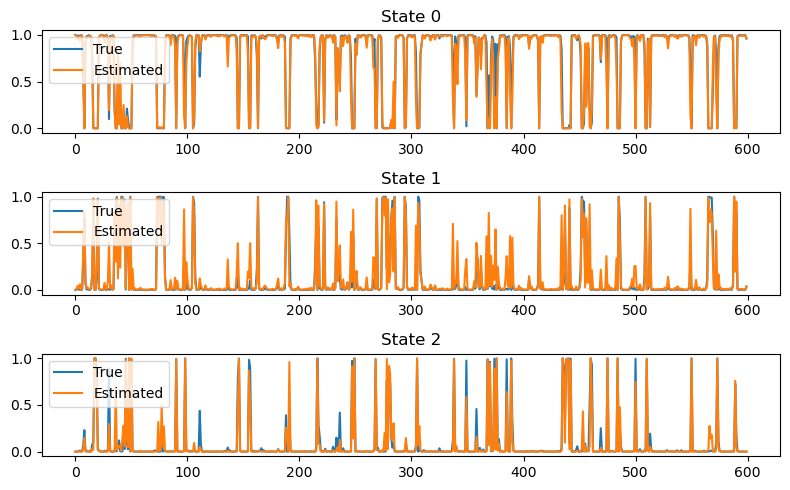

In [9]:
fig, axs = plt.subplots(figsize=(8, 5), nrows=3)
for s in range(NUM_STATES):
    axs[s].plot(G[:, s])
    axs[s].plot(G_hat[:, s])
    axs[s].set_title(f"State {s}")
    axs[s].legend(["True", "Estimated"], ncols=1, loc="upper left")

plt.tight_layout()

In [10]:
# Estimated parameters
collect_params_hat = {}
for i in range(NUM_STOCKS):
    y = R[:, i]
    
    state_params = []
    for s in range(NUM_STATES):
        w = G_hat[:, s]
        mdl = sm.WLS(y, X, weights=w).fit()
        _midx = pd.MultiIndex.from_product([FCTRS, [s]], names=["factor", "state"])
        b = pd.Series(mdl.params.copy(), index=_midx)
        state_params += [b]
        collect_scale[(i, s)] = mdl.scale

    collect_params_hat[i] = pd.concat(state_params)

B_hat = pd.DataFrame.from_dict(collect_params_hat).stack()
B_hat.index.names = ["factor", "state", "stock"]

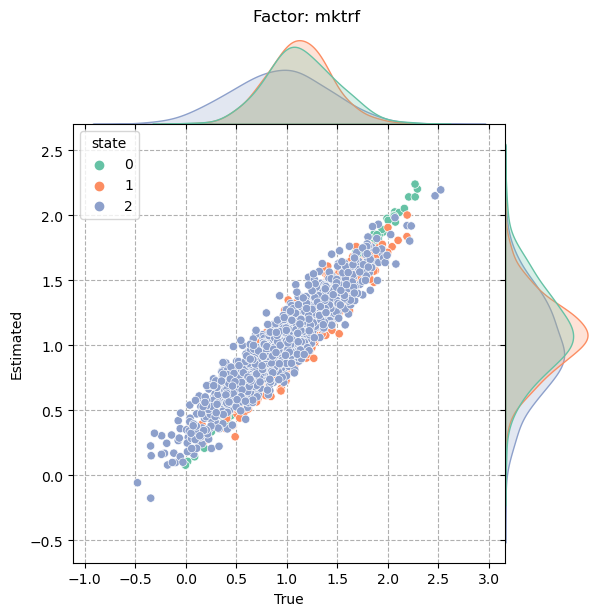

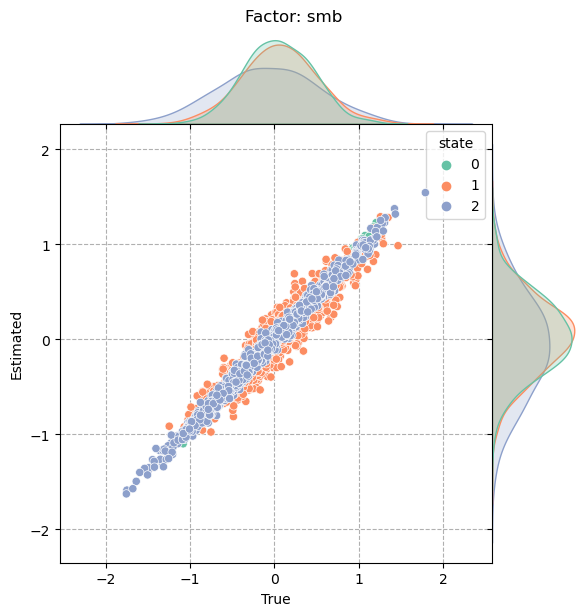

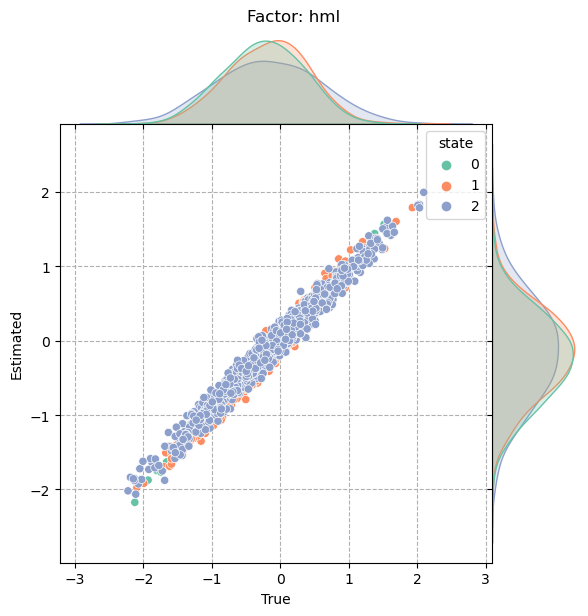

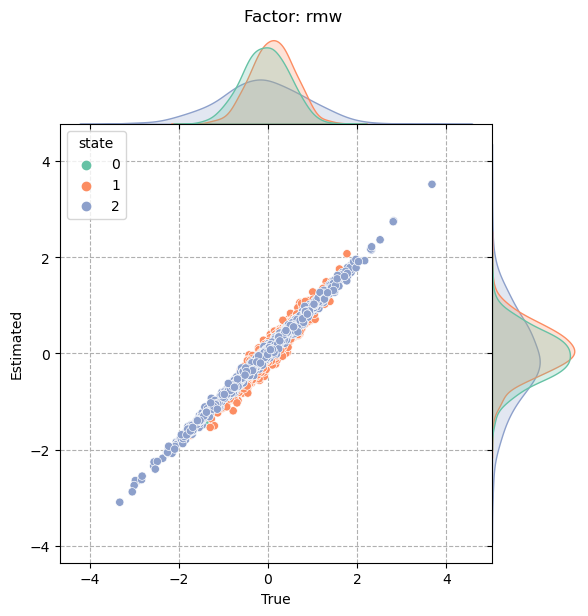

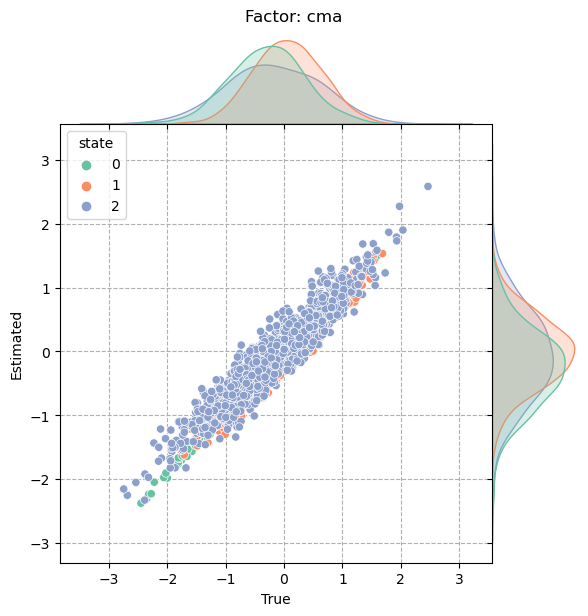

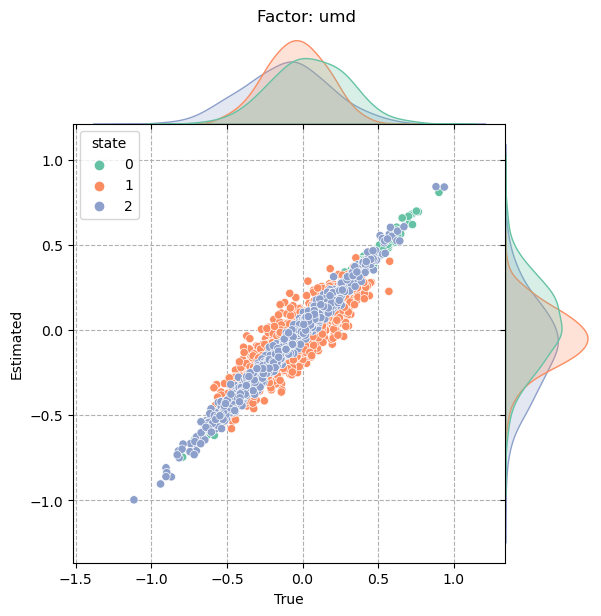

In [11]:
reco = pd.concat([B, B_hat], axis=1)
reco.columns = pd.Index(["True", "Estimated"], name="Loading")

for f in FCTRS:
    data = reco.xs(f, level="factor")
    g = sns.jointplot(data, x="True", y="Estimated", hue="state", space=0, palette="Set2", zorder=25, marginal_kws=dict(bw_adjust=1.25))
    g.ax_joint.grid(ls='--', zorder=-25)
    g.fig.suptitle(f"Factor: {f}", y=1.02)